In [1]:
from ising import IsingDeNoise
import matplotlib.cm as cm
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

### Helper functions for computing images metrics

In [2]:
def compute_clumpiness(Z):
    h, w = Z.shape
    total = 0
    count = 0

    for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:  # 4 neighbors
        shifted = np.roll(Z, shift=(dx, dy), axis=(0, 1))
        agreement = (Z * shifted + 1) / 2  # 1 if same, 0 if different
        total += agreement.sum()
        count += h * w

    return total / count


def calculate_f1_score(original, cleaned):
    true_positive = np.sum((original == 1) & (cleaned == 1))
    false_positive = np.sum((original == -1) & (cleaned == 1))
    false_negative = np.sum((original == 1) & (cleaned == -1))

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

def calculate_accuracy(original, cleaned):
    correct_predictions = np.sum(original == cleaned)
    total_predictions = original.size
    return correct_predictions / total_predictions


def create_noisy_image(Z, q=0.9):
    noise = np.random.random(size = Z.size).reshape(Z.shape) > q
    noisy = np.array(Z)
    noisy[noise] = -noisy[noise]
    return noisy


def dice_score(pred: np.ndarray, target: np.ndarray) -> float:
    pred = pred.flatten()
    target = target.flatten()

    # Zamień -1 → 1, 1 → 0
    pred = (pred == -1).astype(np.uint8)
    target = (target == -1).astype(np.uint8)

    intersection = np.sum(pred & target)
    total = np.sum(pred) + np.sum(target)

    if total == 0:
        return 1.0  # Obie maski puste

    return 2.0 * intersection / total

### Loading data 

In [16]:
# original images
df = pd.read_csv('data/fashion-mnist_test.csv')
labels = df['label'].values

df.drop(columns=['label'], inplace=True)
df = df.values.reshape(-1, 28, 28)
# convert to binary values
df_binary = np.where(df < 128, -1, 1)

In [4]:
# Noisy images
noisy_images = np.load("data/noisy_images_fashion_mnist.npy")

In [8]:
# Denoised images
fashion_mnist_denoised = np.load("data/fashion_mnist_denoised.npy")

### Compute metrics

In [9]:
clumpiness = np.array([compute_clumpiness(img) for img in df_binary])

In [10]:
f1_scores = np.array([calculate_f1_score(img, noisy_img) for img, noisy_img in zip(df_binary, fashion_mnist_denoised)])

In [11]:
accuracies = np.array([calculate_accuracy(img, noisy_img) for img, noisy_img in zip(df_binary, fashion_mnist_denoised)])

In [15]:
dice_scores_denoised = np.array([dice_score(img, noisy_img) for img, noisy_img in zip(df_binary, fashion_mnist_denoised)])

dice_scores_noisy = np.array([dice_score(img, noisy_img) for img, noisy_img in zip(df_binary, noisy_images)])

### Plotting results

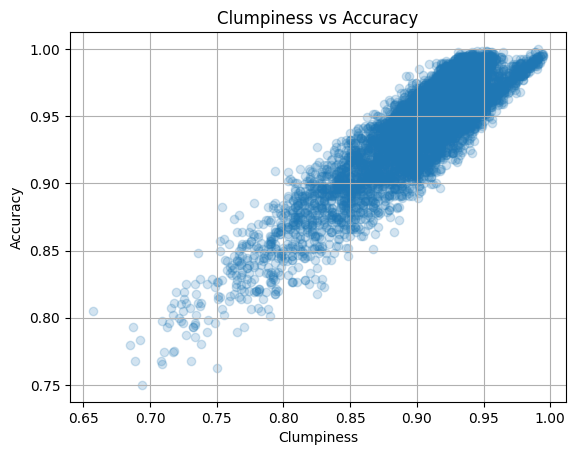

In [13]:
plt.scatter(clumpiness, accuracies, alpha=0.2)
plt.xlabel('Clumpiness')
plt.ylabel('Accuracy')
plt.title('Clumpiness vs Accuracy')
plt.grid()
plt.show()

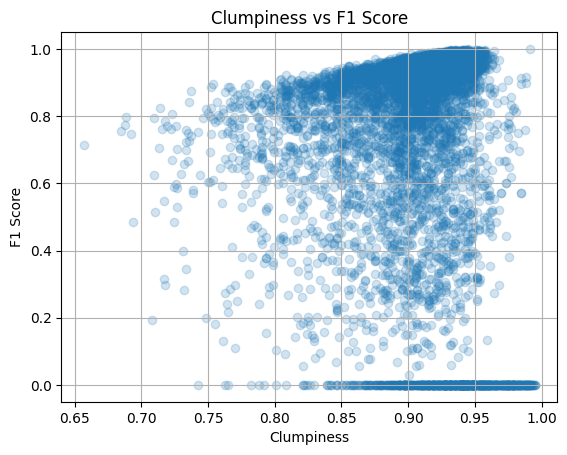

In [14]:
plt.scatter(clumpiness, f1_scores, alpha=0.2)
plt.title('Clumpiness vs F1 Score')
plt.xlabel('Clumpiness')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_dice_boxplots_by_label(dice_scores_denoised, dice_scores_noisy, labels, highlight_label=None):
    # Tworzenie DataFrame z wynikami
    df = pd.DataFrame({
        'denoised_dice': dice_scores_denoised,
        'noise_dice': dice_scores_noisy,
        'label': labels
    })
    
    # Obliczenie poprawy
    df["improvement"] = df["denoised_dice"] - df["noise_dice"]
    
    # Sortowanie etykiet
    unique_labels = sorted(df['label'].unique())
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Wykres dla denoised
    sns.boxplot(data=df, x="label", y="denoised_dice", ax=axes[0], order=unique_labels)
    axes[0].set_title("Denoised Dice by Label")
    axes[0].set_xlabel("Label")
    axes[0].set_ylabel("Dice score")
    if highlight_label is not None:
        highlight_idx = unique_labels.index(highlight_label)
        axes[0].axvline(x=highlight_idx, color="red", linestyle="--")

    # Wykres dla noisy
    sns.boxplot(data=df, x="label", y="noise_dice", ax=axes[1], order=unique_labels)
    axes[1].set_title("Noisy Dice by Label")
    axes[1].set_xlabel("Label")
    axes[1].set_ylabel("")
    if highlight_label is not None:
        highlight_idx = unique_labels.index(highlight_label)
        axes[1].axvline(x=highlight_idx, color="red", linestyle="--")

    # Wykres dla poprawy
    sns.boxplot(data=df, x="label", y="improvement", ax=axes[2], order=unique_labels)
    axes[2].set_title("Improvement (denoised - noisy) by Label")
    axes[2].set_xlabel("Label")
    axes[2].set_ylabel("")
    if highlight_label is not None:
        highlight_idx = unique_labels.index(highlight_label)
        axes[2].axvline(x=highlight_idx, color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

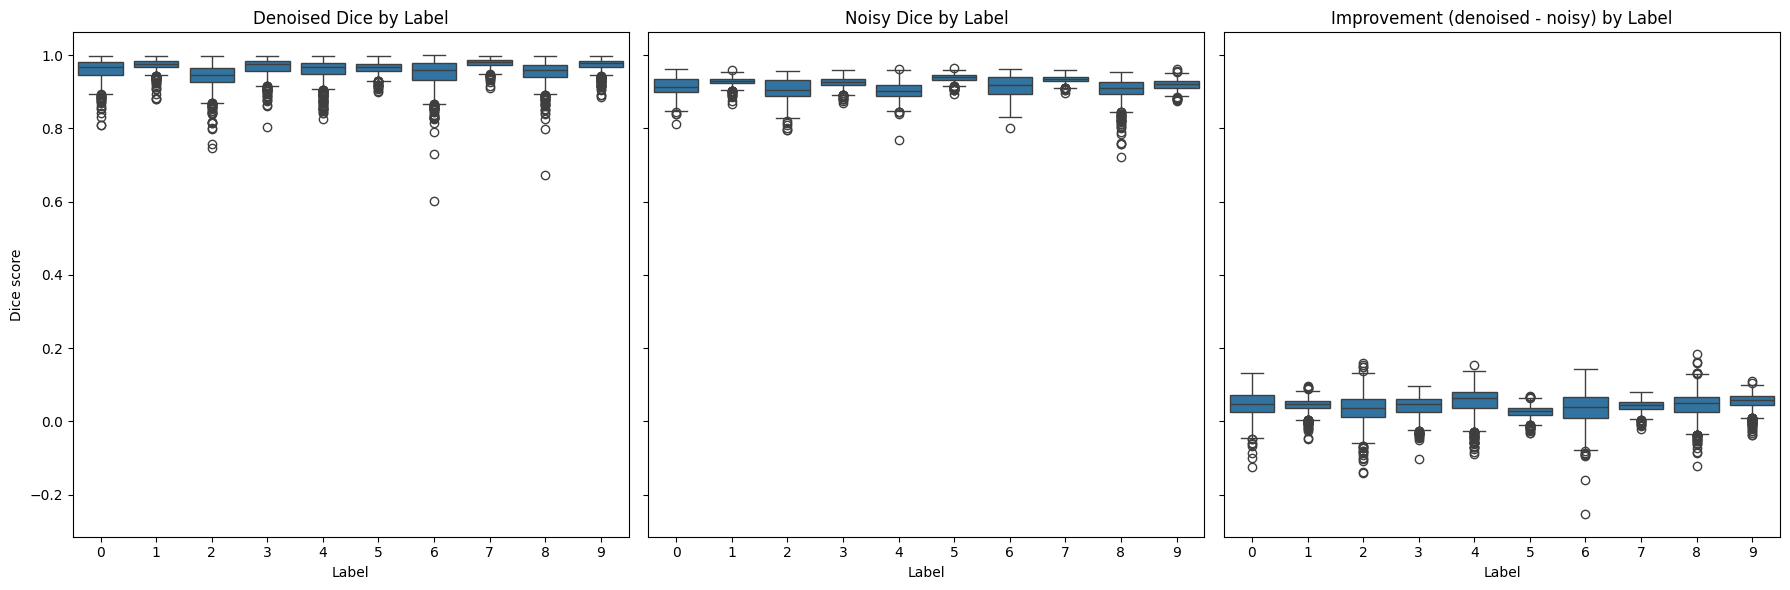

In [19]:
plot_dice_boxplots_by_label(dice_scores_denoised, dice_scores_noisy, labels)

### Top and bottom images based on clumpiness before and after denoising

In [55]:
clean_images = np.array(fashion_mnist_denoised)

# 10 imates with highest clumpiness   
highest_clumpiness_indices = np.argsort(clumpiness)[-1010:-1000]
highest_clumpiness_images = df_binary[highest_clumpiness_indices]
highest_clumpiness_images_denoised = clean_images[highest_clumpiness_indices]
highest_clumpiness_images_noisy = noisy_images[highest_clumpiness_indices]

# 10 images with lowest clumpiness
lowest_clumpiness_indices = np.argsort(clumpiness)[:10]
lowest_clumpiness_images = df_binary[lowest_clumpiness_indices]
lowest_clumpiness_images_denoised = clean_images[lowest_clumpiness_indices]
lowest_clumpiness_images_noisy = noisy_images[lowest_clumpiness_indices]

Text(0.5, 0.93, 'Images with the Highest Clumpiness')

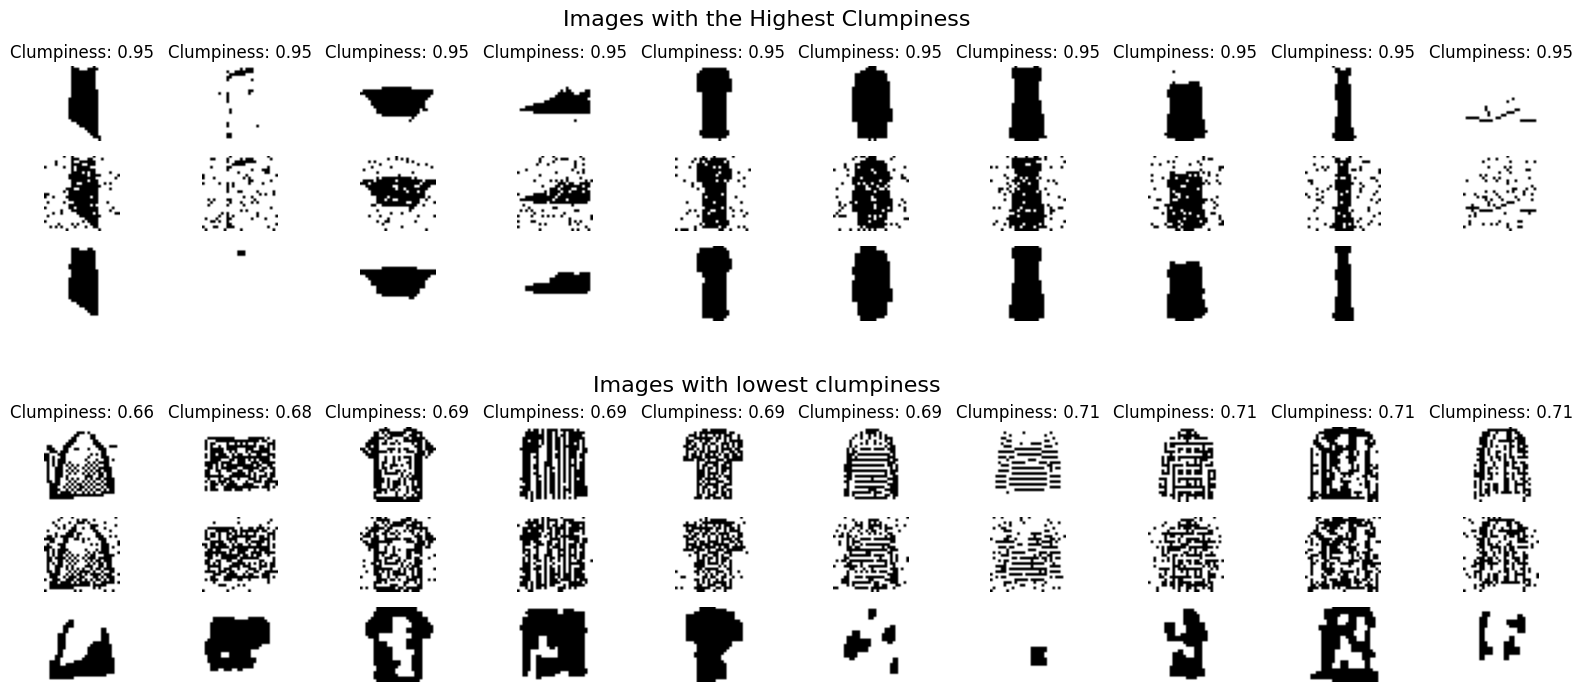

In [61]:
fig, axes = plt.subplots(7, 10, figsize=(20, 8))
for i, img in enumerate(highest_clumpiness_images):
    axes[0, i].imshow(img, cmap='binary')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Clumpiness: {clumpiness[highest_clumpiness_indices[i]]:.2f}')

for i, img in enumerate(highest_clumpiness_images_noisy):
    axes[1, i].imshow(img, cmap='binary')
    axes[1, i].axis('off')
    # axes[2, i].set_title(f'Clumpiness: {clumpiness[highest_clumpiness_indices[i]]:.2f}')

for i, img in enumerate(highest_clumpiness_images_denoised):
    axes[2, i].imshow(img, cmap='binary')
    axes[2, i].axis('off')
    # axes[1, i].set_title(f'Clumpiness: {clumpiness[highest_clumpiness_indices[i]]:.2f}')

for i in range(10):
    axes[3, i].set_xticks([])
    axes[3, i].set_yticks([])
    axes[3, i].axis('off')  


fig.text(0.5, 0.48, 'Images with lowest clumpiness', ha='center', va='center', fontsize=16)

for i, img in enumerate(lowest_clumpiness_images):
    axes[4, i].imshow(img, cmap='binary')
    axes[4, i].axis('off')
    axes[4, i].set_title(f'Clumpiness: {clumpiness[lowest_clumpiness_indices[i]]:.2f}')

for i, img in enumerate(lowest_clumpiness_images_noisy):
    axes[5, i].imshow(img, cmap='binary')
    axes[5, i].axis('off')
    # axes[5, i].set_title(f'Clumpiness: {clumpiness[lowest_clumpiness_indices[i]]:.2f}')

for i, img in enumerate(lowest_clumpiness_images_denoised):
    axes[6, i].imshow(img, cmap='binary')
    axes[6, i].axis('off')
    # axes[4, i].set_title(f'Clumpiness: {clumpiness[lowest_clumpiness_indices[i]]:.2f}')


fig.text(0.5, 0.93, 'Images with the Highest Clumpiness', ha='center', fontsize=16)

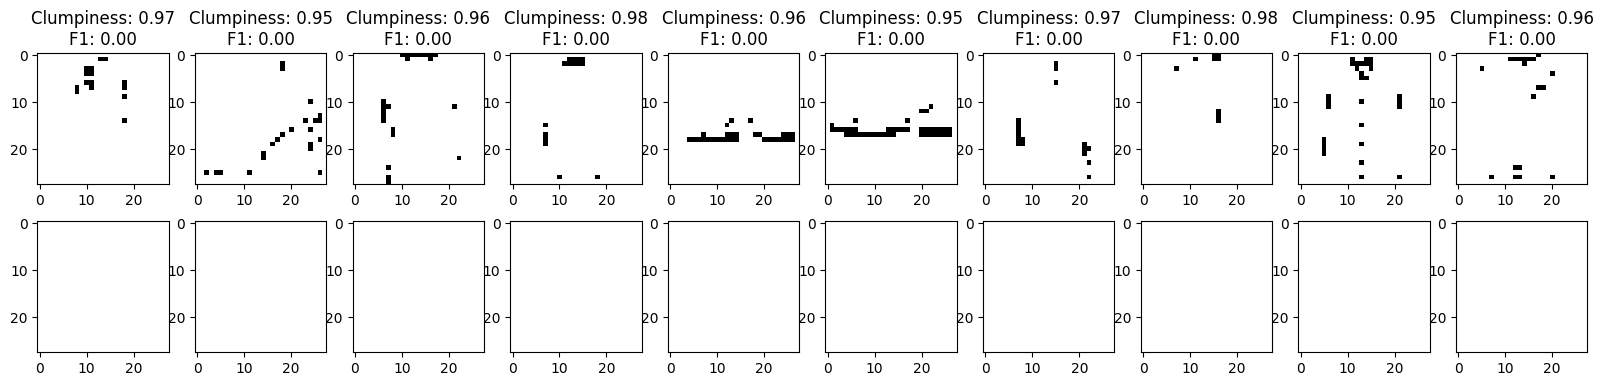

In [80]:
low_f1_high_clumpiness_idxs = np.where((f1_scores < 0.1) & (clumpiness > 0.95))[0]
low_f1_high_clumpiness_idxs = np.random.choice(low_f1_high_clumpiness_idxs, size=10, replace=False)
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i, idx in enumerate(low_f1_high_clumpiness_idxs):
    axes[0, i].imshow(df_binary[idx], cmap='binary')
    # axes[0, i].axis('off')
    axes[0, i].set_title(f'Clumpiness: {clumpiness[idx]:.2f}\nF1: {f1_scores[idx]:.2f}')

for i, idx in enumerate(low_f1_high_clumpiness_idxs):
    axes[1, i].imshow(clean_images[idx], cmap='binary')
    # axes[1, i].axis('off')
    # axes[1, i].set_title(f'Clumpiness: {clumpiness[idx]:.2f}\nF1: {f1_scores[idx]:.2f}')
